# Bot Classification - OSRS

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import pandas as pd
import numpy as np
%matplotlib inline

# Initialize plotting library and functions for 3D scatter plots 
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_classification, make_regression
from sklearn.externals import six
import argparse
import json
import re
import os
import sys
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

C:\Users\User\Anaconda3\envs\banbot\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
import seaborn as sns
from scipy import stats

## Cleaning The Data

In [3]:
player_df = pd.read_csv('./data/player_data_04-2020.csv')
print('original shape: {}'.format(player_df.shape))
player_df = player_df.drop_duplicates(subset="Name")
print('shape after removing duplicates: {}'.format(player_df.shape))
player_df = player_df[player_df['Overall'] != -1]
print('shape after removing failed hiscores: {}'.format(player_df.shape))
player_df.head()

original shape: (2429, 41)
shape after removing duplicates: (2320, 41)
shape after removing failed hiscores: (2227, 41)


Name  helmet  cape  amulet  weapon  body  sheild  Equip7  legs  \
0       Aweb0kz      -1    -1      -1      -1    -1      -1      -1    -1   
1    Popeye2018      -1    -1    1660     853    -1      -1      -1  1099   
2  ImFatNotCute      -1    -1      -1      -1    -1      -1      -1    -1   
3     PappoSeco      -1    -1      -1      -1    -1      -1      -1    -1   
4     GB Justin      -1    -1      -1    1381    -1      -1      -1    -1   

   Equip9  ...  Mining  Herblore  Agility  Thieving  Slayer  Farming  \
0      -1  ...      60         1        1         1       1        1   
1      -1  ...      83         1       10         1       1        1   
2      -1  ...      41        30       25        20      63       17   
3      -1  ...      41         1        1         1       1        1   
4      -1  ...       1         1       37        19      33        1   

   Runecrafting  Hunter  Construction  Location  
0             1       1             1        ge  
1            30       1             1        ge  
2             9       1             1        ge  
3             1       1             1        ge  
4             1       1            27        ge  

[5 rows x 41 columns]

In [4]:
player_df['Location'].value_counts()

ge             773
lumbridge      467
attack         410
mining         351
woodcutting    146
fishing         80
Name: Location, dtype: int64

In [5]:
f2p_array = ['Attack', 'Defence', 'Strength','Hitpoints', 'Ranged', 'Prayer', 'Magic', 'Cooking', 'Woodcutting',\
           'Runecrafting', 'Fishing', 'Firemaking', 'Crafting', 'Smithing', 'Mining']

player_df.columns

Index(['Name', 'helmet', 'cape', 'amulet', 'weapon', 'body', 'sheild',
       'Equip7', 'legs', 'Equip9', 'gloves', 'boots', 'Equip12', 'Loc_x',
       'Loc_y', 'Anim_id', 'Overall', 'Attack', 'Defence', 'Strength',
       'Hitpoints', 'Ranged', 'Prayer', 'Magic', 'Cooking', 'Woodcutting',
       'Fletching', 'Fishing', 'Firemaking', 'Crafting', 'Smithing', 'Mining',
       'Herblore', 'Agility', 'Thieving', 'Slayer', 'Farming', 'Runecrafting',
       'Hunter', 'Construction', 'Location'],
      dtype='object')

## Exploring The Full Dataset (currently only skills)

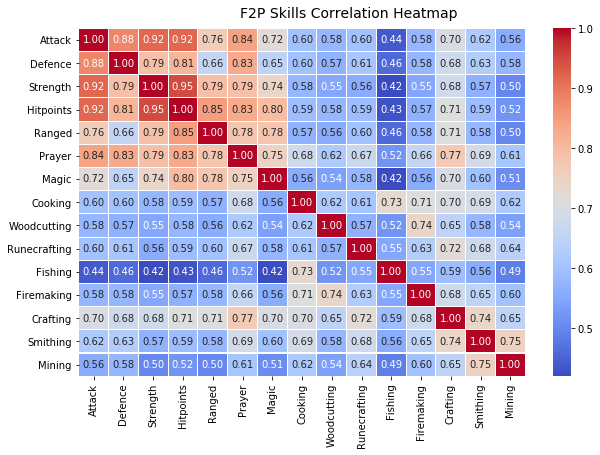

In [6]:
full_df = player_df[f2p_array]

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = full_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('F2P Skills Correlation Heatmap', fontsize=14)

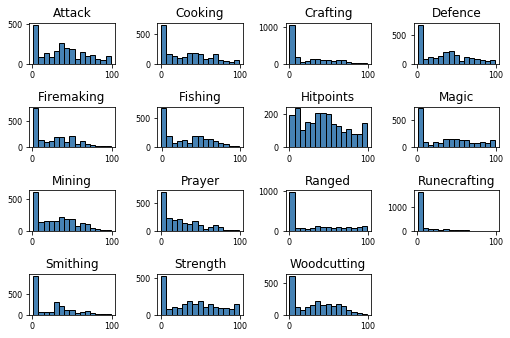

In [7]:
full_df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))  

C:\Users\User\Anaconda3\envs\banbot\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



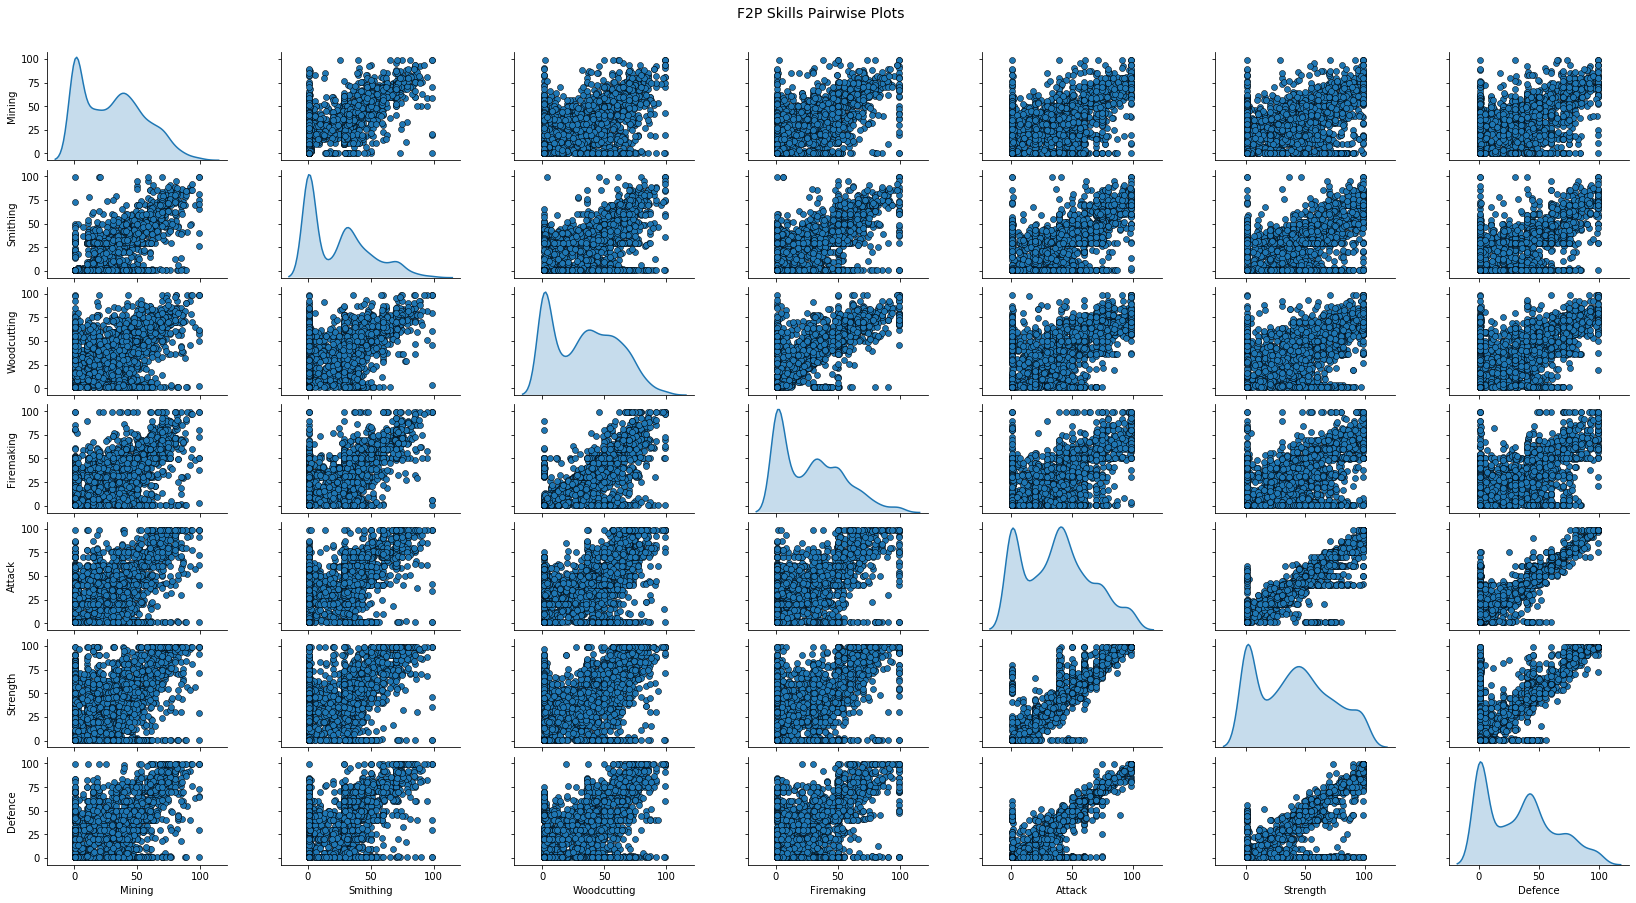

In [8]:
# Pair-wise Scatter Plots
cols = ['Mining', 'Smithing', 'Woodcutting', 'Firemaking', 'Attack', 'Strength', 'Defence']
pp = sns.pairplot(full_df[cols], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('F2P Skills Pairwise Plots', fontsize=14)

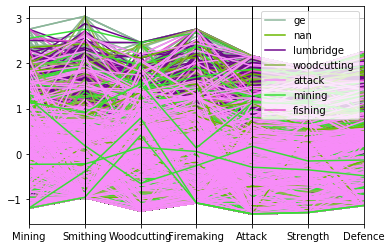

In [9]:
# Scaling attribute values to avoid few outliers
cols = ['Mining', 'Smithing', 'Woodcutting', 'Firemaking', 'Attack', 'Strength', 'Defence']
subset_df = full_df[cols]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, player_df['Location']], axis=1)
final_df.head()

# plot parallel coordinates
from pandas.plotting import parallel_coordinates
pc = parallel_coordinates(final_df, 'Location')

Text(0, 0.5, 'Level')

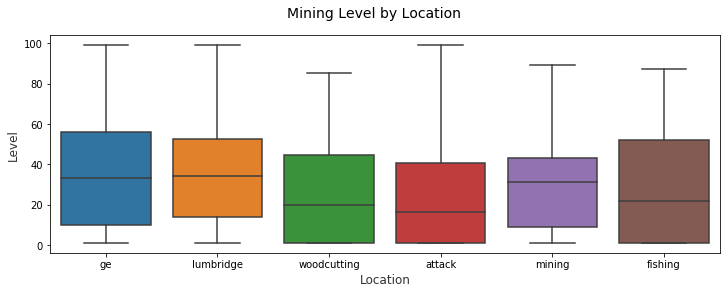

In [10]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Mining Level by Location', fontsize=14)

sns.boxplot(x="Location", y="Mining", data=player_df,  ax=ax)
ax.set_xlabel("Location",size = 12,alpha=0.8)
ax.set_ylabel("Level",size = 12,alpha=0.8)

## Exploring Skilling vs Chilling Areas

(1124, 41)


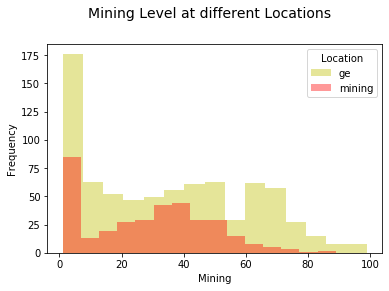

In [11]:
skill_areas = ["woodcutting", "attack", "mining", "fishing"]
chill_areas = ["ge", "lumbridge"]

split_df = player_df.loc[player_df['Location'].isin(['mining', 'ge'])]
split_df = split_df.reset_index(drop=True)
print(split_df.shape)

# Using multiple Histograms 
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("Mining Level at different Locations", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Mining Level")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(split_df, hue='Location', palette={"mining": "r", "ge": "y"})
g.map(sns.distplot, 'Mining', kde=False, bins=15, ax=ax)
ax.legend(title='Location')
plt.close(2)

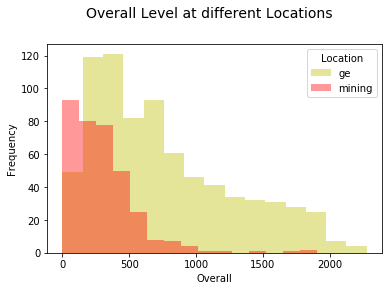

In [12]:
# Using multiple Histograms 
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("Overall Level at different Locations", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Overall Level")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(split_df, hue='Location', palette={"mining": "r", "ge": "y"})
g.map(sns.distplot, 'Overall', kde=False, bins=15, ax=ax)
ax.legend(title='Location')
plt.close(2)

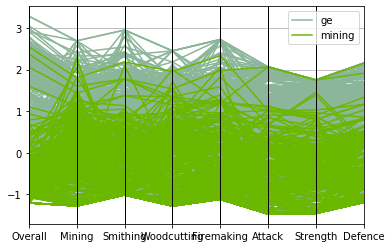

In [13]:
# Scaling attribute values to avoid few outliers
cols = ['Overall', 'Mining', 'Smithing', 'Woodcutting', 'Firemaking', 'Attack', 'Strength', 'Defence']
subset_df = split_df[cols]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, split_df['Location']], axis=1)
final_df.head()

# plot parallel coordinates
from pandas.plotting import parallel_coordinates
pc = parallel_coordinates(final_df, 'Location')

C:\Users\User\Anaconda3\envs\banbot\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



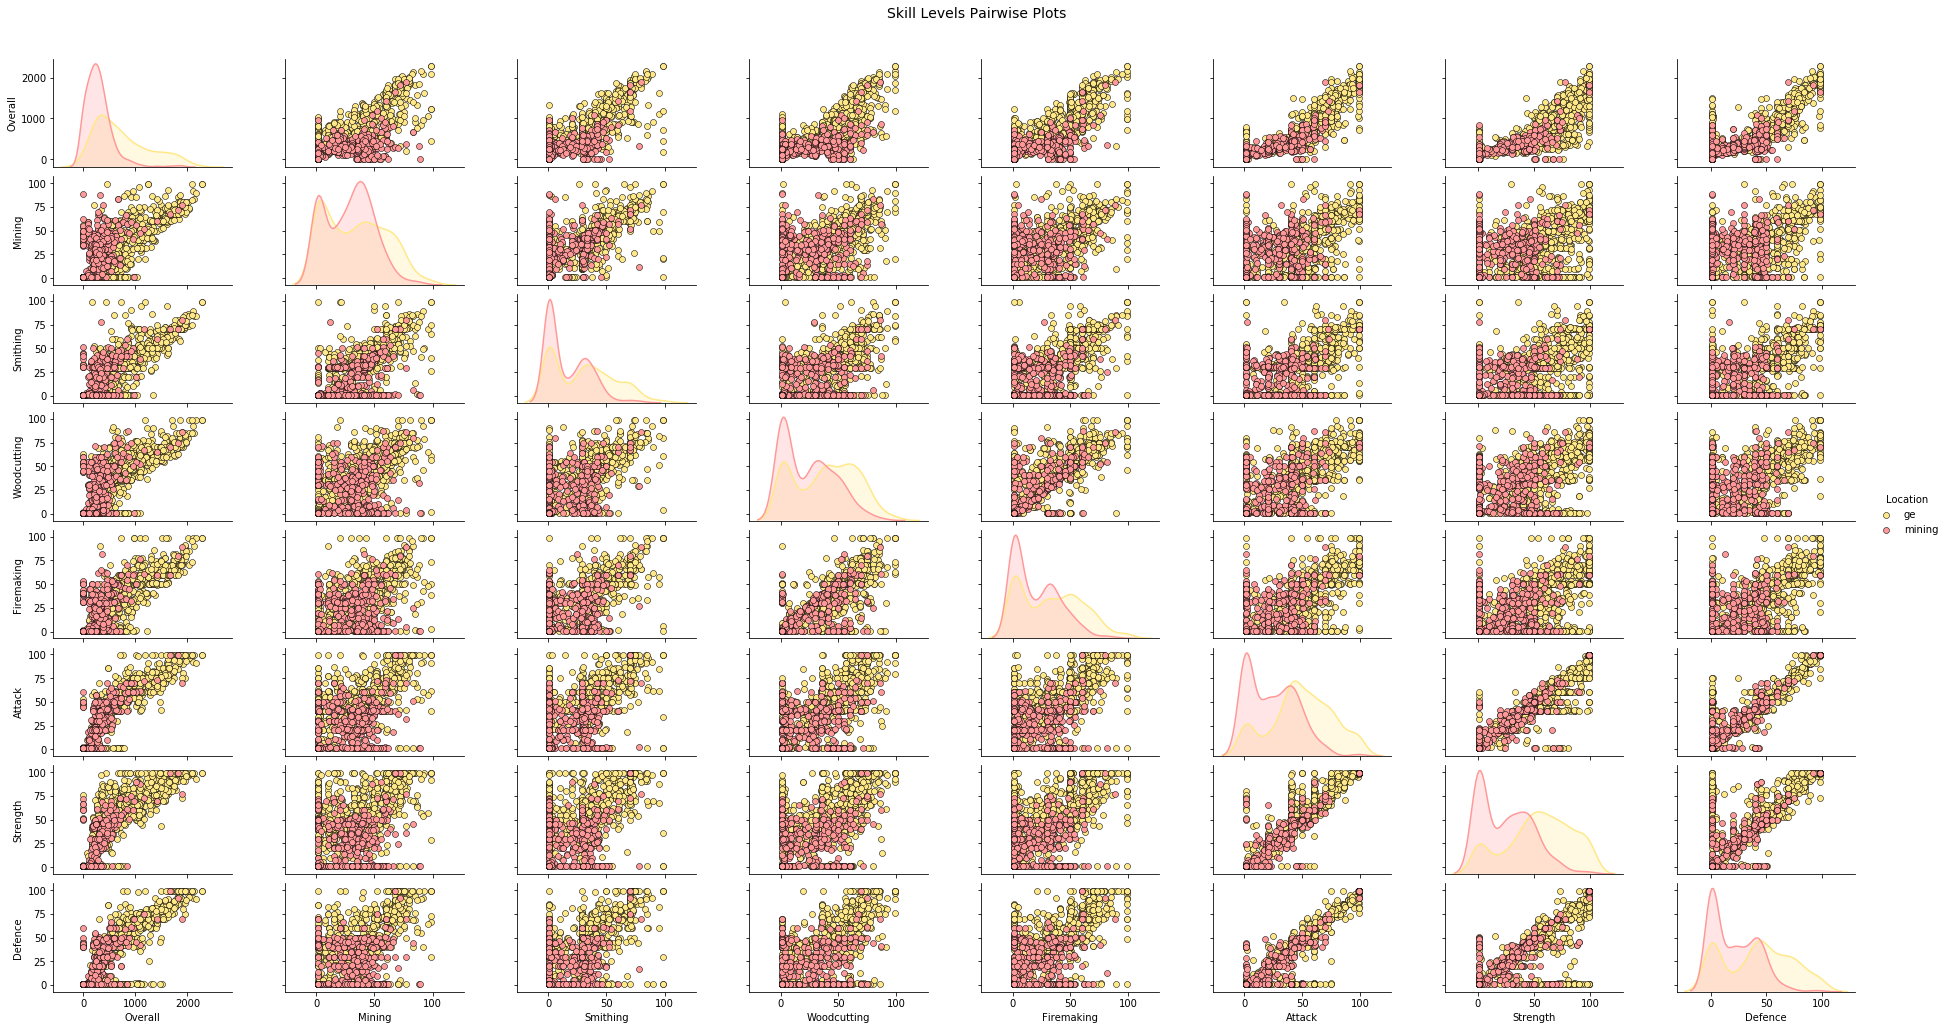

In [14]:
# Scatter Plot with Hue for visualizing data in 3-D
cols = ['Overall', 'Mining', 'Smithing', 'Woodcutting', 'Firemaking', 'Attack', 'Strength', 'Defence', 'Location']
subset_df = split_df[cols]
pp = sns.pairplot(subset_df, hue='Location', size=1.8, aspect=1.8, 
                  palette={"mining": "#FF9999", "ge": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Skill Levels Pairwise Plots', fontsize=14)

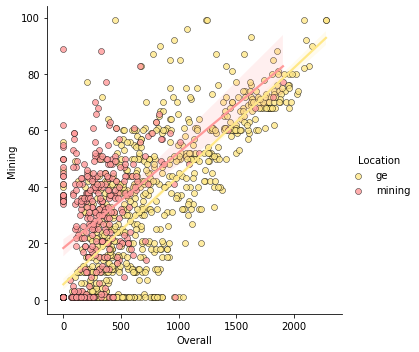

In [15]:
# we can also view relationships\correlations as needed                  
lp = sns.lmplot(x='Overall', y='Mining', hue='Location', 
                palette={"mining": "#FF9999", "ge": "#FFE888"},
                data=subset_df, fit_reg=True, legend=True,
                scatter_kws=dict(edgecolor="k", linewidth=0.5))       

In [16]:
cols = ['Overall', 'Mining', 'Smithing', 'Woodcutting', 'Firemaking', 'Attack', 'Strength', 'Defence']
subset_df = split_df[cols]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, split_df['Location']], axis=1)
print(final_df.shape)

melted_skill_df = pd.melt(final_df, id_vars=['Location'], value_vars=['Overall', 'Mining', 'Smithing', 'Woodcutting', 'Firemaking', 'Attack', 'Strength', 'Defence'])

(1124, 9)


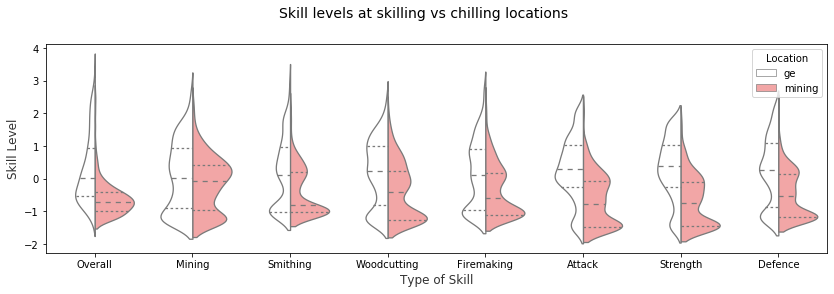

In [17]:
fig = plt.figure(figsize = (14, 4))
title = fig.suptitle("Skill levels at skilling vs chilling locations", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax2 = fig.add_subplot(1,1, 1)
sns.violinplot(x='variable', y='value', hue='Location', 
               data=melted_skill_df, split=True, inner="quart", linewidth=1.3,
               palette={"mining": "#FF9999", "ge": "white"})
ax2.set_xlabel("Type of Skill",size = 12,alpha=0.8)
ax2.set_ylabel("Skill Level",size = 12,alpha=0.8)
l = plt.legend(loc='upper right', title='Location')

## Feature Engineering Time!

In [18]:
eng_df = player_df.copy()  # create copy of complete df to engineer features onto

Starting with simple but important features like number of items equipped and a skill ratio index

In [19]:
equip_list = ['helmet', 'cape', 'amulet', 'weapon', 'body', 'sheild','Equip7', 'legs', 'Equip9', 'gloves', 'boots', 'Equip12']
def count_equipment (row):
    total_equipment = 0
    for equip_name in equip_list:
        if (row[equip_name] != -1):
            total_equipment += 1
    return total_equipment

eng_df['equip_count'] = eng_df.apply (lambda row: count_equipment(row), axis=1)
eng_df[equip_list + ['equip_count']].head()

helmet  cape  amulet  weapon  body  sheild  Equip7  legs  Equip9  gloves  \
0      -1    -1      -1      -1    -1      -1      -1    -1      -1      -1   
1      -1    -1    1660     853    -1      -1      -1  1099      -1    1065   
2      -1    -1      -1      -1    -1      -1      -1    -1      -1      -1   
3      -1    -1      -1      -1    -1      -1      -1    -1      -1      -1   
4      -1    -1      -1    1381    -1      -1      -1    -1      -1      -1   

   boots  Equip12  equip_count  
0     -1       -1            0  
1     -1       -1            4  
2     -1       -1            0  
3     -1       -1            0  
4     -1       -1            1

Text(0, 0.5, 'Number of Items Equipped')

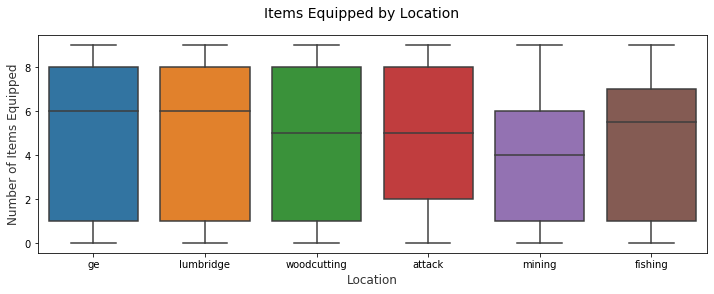

In [20]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Items Equipped by Location', fontsize=14)

sns.boxplot(x="Location", y="equip_count", data=eng_df,  ax=ax)
ax.set_xlabel("Location",size = 12,alpha=0.8)
ax.set_ylabel("Number of Items Equipped",size = 12,alpha=0.8)

In [21]:
f2p_array = ['Attack', 'Defence', 'Strength','Hitpoints', 'Ranged', 'Prayer', 'Magic', 'Cooking', 'Woodcutting',\
           'Runecrafting', 'Fishing', 'Firemaking', 'Crafting', 'Smithing', 'Mining']

def count_skills_above_10 (row):
    total_skills = 0
    for skill_name in f2p_array:
        if (row[skill_name] > 10):
            total_skills += 1
    return total_skills

eng_df['skills_above_10'] = eng_df.apply (lambda row: count_skills_above_10(row), axis=1)
eng_df[f2p_array + ['skills_above_10']].head()

Attack  Defence  Strength  Hitpoints  Ranged  Prayer  Magic  Cooking  \
0      40       41        44         42       1       2      1       66   
1       1       40         1         54      64       1      1       68   
2      60       55        57         68      74      42     58       50   
3      40       40        40         36       1      31     55        4   
4      70       62        75         69       1      43      1        1   

   Woodcutting  Runecrafting  Fishing  Firemaking  Crafting  Smithing  Mining  \
0           70             1       70          70         1         1      60   
1           60            30       60          60        88        47      83   
2           43             9       24          41        44        40      41   
3           41             1        1           1         9        29      41   
4            1             1        1           1        31         1       1   

   skills_above_10  
0                9  
1               11  
2               14  
3                9  
4                6

Text(0, 0.5, 'Number of Skills Above 10')

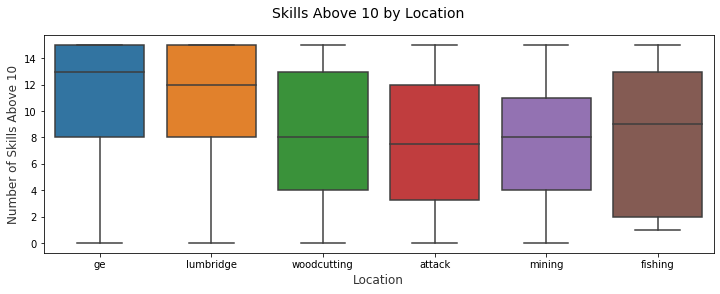

In [22]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Skills Above 10 by Location', fontsize=14)

sns.boxplot(x="Location", y="skills_above_10", data=eng_df,  ax=ax)
ax.set_xlabel("Location",size = 12,alpha=0.8)
ax.set_ylabel("Number of Skills Above 10",size = 12,alpha=0.8)

In [23]:
f2p_array = ['Attack', 'Defence', 'Strength','Hitpoints', 'Ranged', 'Prayer', 'Magic', 'Cooking', 'Woodcutting',\
           'Runecrafting', 'Fishing', 'Firemaking', 'Crafting', 'Smithing', 'Mining']

import math 
# Combat levels taken from https://oldschool.runescape.wiki/w/Combat_level

# Base = 0.25(Defence + Hitpoints + floor(Prayer/2))
def base_level (row):
    return 0.25 * (row['Defence'] + row['Hitpoints'] + math.floor(row['Prayer']/2))

# Melee = 0.325(Attack + Strength)
def melee_level (row):
    return 0.325 * (row['Attack'] + row['Strength'])

# Range = 0.325(floor(3*Ranged/2))
def range_level (row):
    return 0.325 * math.floor((row['Ranged'] * 3)/2)

# Mage = 0.325(floor(3*Magic/2))
def magic_level (row):
    return 0.325 * math.floor((row['Magic'] * 3)/2)

# Final = floor(Base + Highest of Melee, Range or Mage)
def combat_level(row):
    return math.floor(row['Base_level'] + max(row['Melee_level'], row['Range_level'], row['Magic_level']))


eng_df['Base_level'] = eng_df.apply (lambda row: base_level(row), axis=1)
eng_df['Melee_level'] = eng_df.apply (lambda row: melee_level(row), axis=1)
eng_df['Range_level'] = eng_df.apply (lambda row: range_level(row), axis=1)
eng_df['Magic_level'] = eng_df.apply (lambda row: magic_level(row), axis=1)
eng_df['Combat_level'] = eng_df.apply (lambda row: combat_level(row), axis=1)

eng_df[['Defence','Hitpoints', 'Prayer', 'Base_level', 'Attack', 'Strength', 'Melee_level', 'Ranged', \
        'Range_level', 'Magic', 'Magic_level', 'Combat_level' ]].head()

Defence  Hitpoints  Prayer  Base_level  Attack  Strength  Melee_level  \
0       41         42       2       21.00      40        44       27.300   
1       40         54       1       23.50       1         1        0.650   
2       55         68      42       36.00      60        57       38.025   
3       40         36      31       22.75      40        40       26.000   
4       62         69      43       38.00      70        75       47.125   

   Ranged  Range_level  Magic  Magic_level  Combat_level  
0       1        0.325      1        0.325            48  
1      64       31.200      1        0.325            54  
2      74       36.075     58       28.275            74  
3       1        0.325     55       26.650            49  
4       1        0.325      1        0.325            85

Text(0, 0.5, 'Combat Levels')

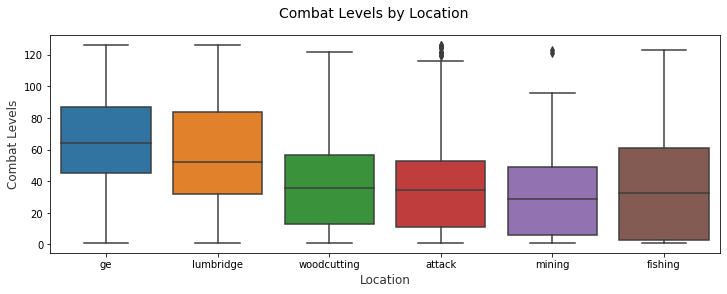

In [24]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Combat Levels by Location', fontsize=14)

sns.boxplot(x="Location", y="Combat_level", data=eng_df,  ax=ax)
ax.set_xlabel("Location",size = 12,alpha=0.8)
ax.set_ylabel("Combat Levels",size = 12,alpha=0.8)

In [25]:
f2p_array = ['Attack', 'Defence', 'Strength','Hitpoints', 'Ranged', 'Prayer', 'Magic', 'Cooking', 'Woodcutting',\
           'Runecrafting', 'Fishing', 'Firemaking', 'Crafting', 'Smithing', 'Mining']
kept_features = ['Name', 'equip_count', 'Location', 'skills_above_10', 'Base_level', 'Melee_level', \
        'Range_level', 'Magic_level', 'Combat_level']
kept_features.extend(f2p_array)

eng_df_selected = eng_df.loc[:, kept_features]

# Add mean and standard deviation of skills as variables
eng_df_selected['skill_mean'] = eng_df_selected[f2p_array].mean(axis=1)
eng_df_selected['skill_std'] = eng_df_selected[f2p_array].std(axis=1)

print(eng_df_selected.shape)
eng_df_selected.head()

(2227, 26)


Name  equip_count Location  skills_above_10  Base_level  \
0       Aweb0kz            0       ge                9       21.00   
1    Popeye2018            4       ge               11       23.50   
2  ImFatNotCute            0       ge               14       36.00   
3     PappoSeco            0       ge                9       22.75   
4     GB Justin            1       ge                6       38.00   

   Melee_level  Range_level  Magic_level  Combat_level  Attack  ...  Cooking  \
0       27.300        0.325        0.325            48      40  ...       66   
1        0.650       31.200        0.325            54       1  ...       68   
2       38.025       36.075       28.275            74      60  ...       50   
3       26.000        0.325       26.650            49      40  ...        4   
4       47.125        0.325        0.325            85      70  ...        1   

   Woodcutting  Runecrafting  Fishing  Firemaking  Crafting  Smithing  Mining  \
0           70             1       70          70         1         1      60   
1           60            30       60          60        88        47      83   
2           43             9       24          41        44        40      41   
3           41             1        1           1         9        29      41   
4            1             1        1           1        31         1       1   

   skill_mean  skill_std  
0   34.000000  29.647934  
1   43.866667  30.375899  
2   47.066667  16.425010  
3   24.666667  19.382122  
4   23.933333  30.887970  

[5 rows x 26 columns]

Decided here to focus purely on the Mining Locations and GE Location

In [26]:
def mining_level_difference (row):
    return math.floor(row['Mining'] - row['skill_mean'])
eng_df_selected['mining_minus_mean'] = eng_df_selected.apply (lambda row: mining_level_difference(row), axis=1)

print(eng_df_selected.shape)
eng_df_selected[['Mining', 'skill_mean','skill_std', 'mining_minus_mean']].head()

(2227, 27)


Mining  skill_mean  skill_std  mining_minus_mean
0      60   34.000000  29.647934                 26
1      83   43.866667  30.375899                 39
2      41   47.066667  16.425010                 -7
3      41   24.666667  19.382122                 16
4       1   23.933333  30.887970                -23

(1124, 27)


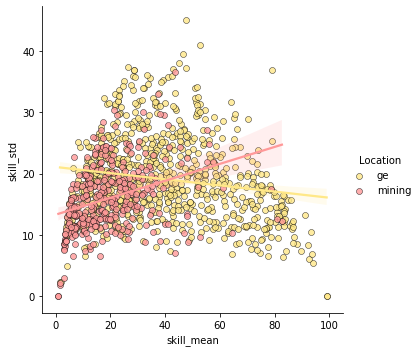

In [27]:
eng_split_df = eng_df_selected.loc[eng_df_selected['Location'].isin(['mining', 'ge'])]
eng_split_df = eng_split_df.reset_index(drop=True)
print(eng_split_df.shape)

# we can also view relationships\correlations as needed                  
lp = sns.lmplot(x='skill_mean', y='skill_std', hue='Location', 
                palette={"mining": "#FF9999", "ge": "#FFE888"},
                data=eng_split_df, fit_reg=True, legend=True,
                scatter_kws=dict(edgecolor="k", linewidth=0.5))       

C:\Users\User\Anaconda3\envs\banbot\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



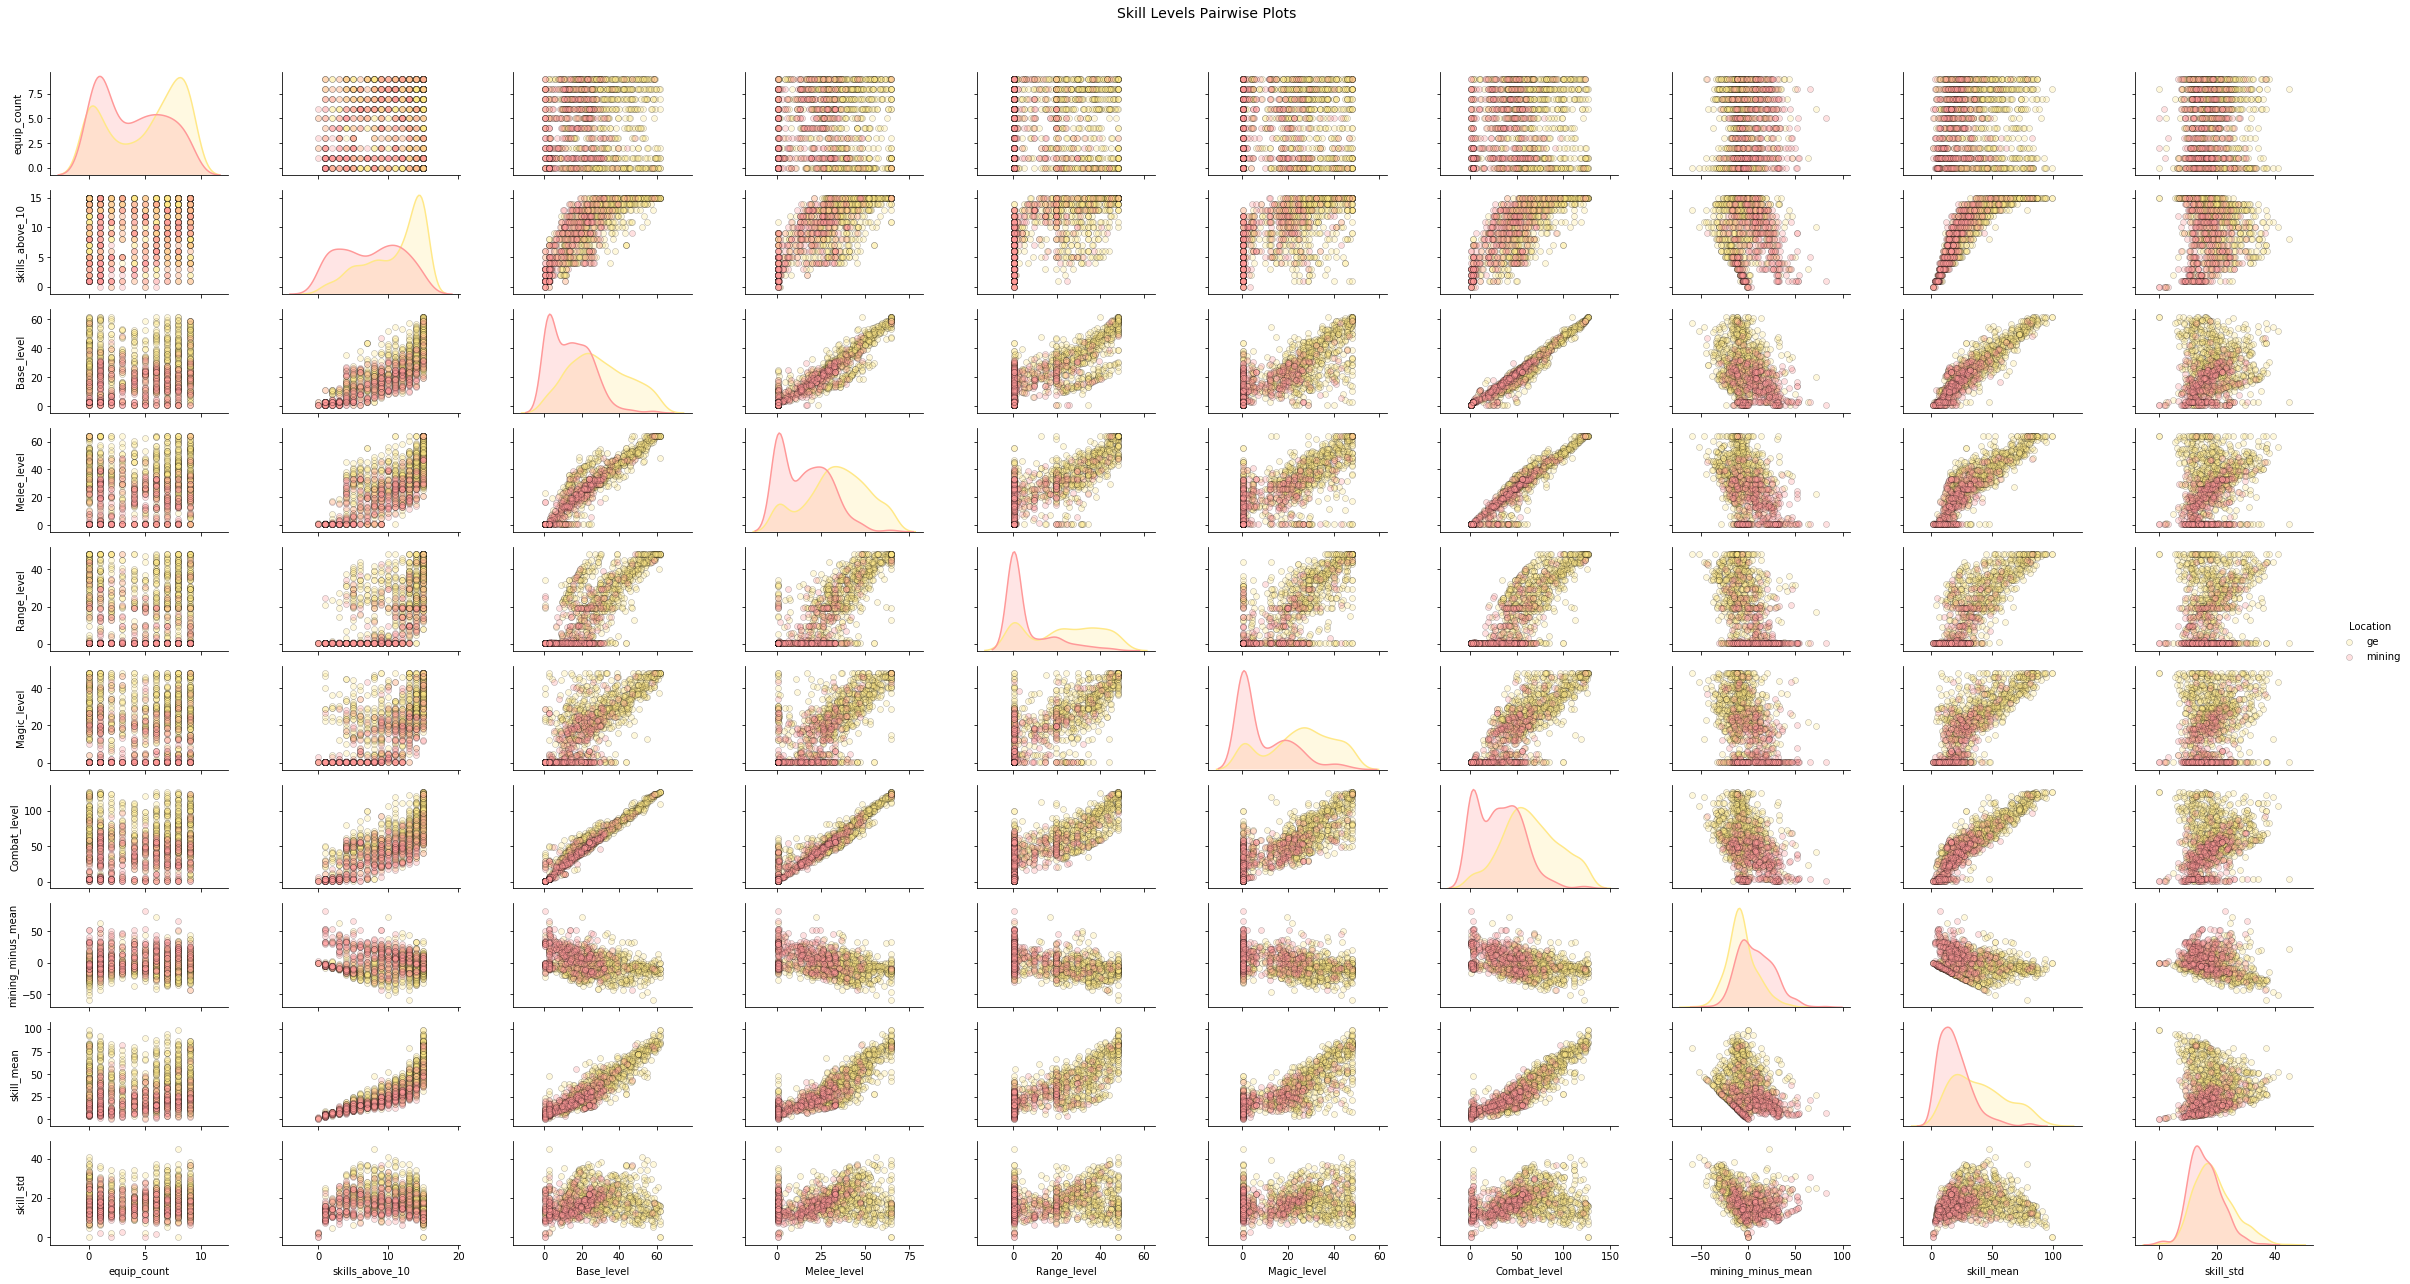

In [28]:
kept_features = ['equip_count', 'Location', 'skills_above_10', 'Base_level', 'Melee_level', \
        'Range_level', 'Magic_level', 'Combat_level', 'mining_minus_mean', 'skill_mean','skill_std' ]

# Scatter Plot with Hue for visualizing data in 3-D
subset_df = eng_split_df.copy()
subset_df = subset_df[kept_features]
pp = sns.pairplot(subset_df, hue='Location', size=1.8, aspect=1.8, 
                  palette={"mining": "#FF9999", "ge": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5, alpha=0.3))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Skill Levels Pairwise Plots', fontsize=14)

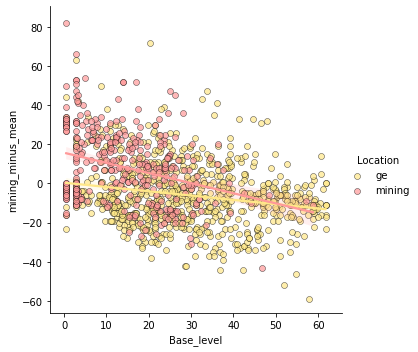

In [29]:
# we can also view relationships\correlations as needed                  
lp = sns.lmplot(x='Base_level', y='mining_minus_mean', hue='Location', 
                palette={"mining": "#FF9999", "ge": "#FFE888"},
                data=eng_split_df, fit_reg=True, legend=True,
                scatter_kws=dict(edgecolor="k", linewidth=0.5, alpha=0.7))       

# TESTING ZONE (BEWARE)

## Feature Selection

In [30]:
subset_df = eng_split_df.copy()
subset_df = subset_df.drop(['Name', 'Location'], axis=1)
subset_df_columns = subset_df.columns

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=subset_df_columns)
final_df = pd.concat([scaled_df, eng_split_df['Location']], axis=1)
print(final_df.shape)
final_df.head()


(1124, 26)


equip_count  skills_above_10  Base_level  Melee_level  Range_level  \
0    -1.431748        -0.194250   -0.226174    -0.056193    -1.030661   
1    -0.203989         0.249976   -0.071323    -1.494847     0.793902   
2    -1.431748         0.916317    0.702935     0.522778     1.081991   
3    -1.431748        -0.194250   -0.117778    -0.126371    -1.030661   
4    -1.124808        -0.860591    0.826816     1.014026    -1.030661   

   Magic_level  Combat_level    Attack   Defence  Strength  ...  Runecrafting  \
0    -1.268778     -0.213217 -0.062272  0.175498 -0.048135  ...     -0.525357   
1    -1.268778     -0.028701 -1.467187  0.141441 -1.452150  ...      0.958314   
2     0.506810      0.586355  0.658198  0.652301  0.376335  ...     -0.116068   
3     0.403578     -0.182465 -0.062272  0.141441 -0.178741  ...     -0.525357   
4    -1.268778      0.924635  1.018432  0.890702  0.964062  ...     -0.525357   

    Fishing  Firemaking  Crafting  Smithing    Mining  skill_mean  skill_std  \
0  1.495833    1.586945 -0.941984 -1.008464  1.113141    0.019636   1.732464   
1  1.123498    1.195477  2.320563  0.849556  2.043982    0.463803   1.841834   
2 -0.216908    0.451686  0.670539  0.566814  0.344186    0.607857  -0.254161   
3 -1.073279   -1.114188 -0.641980  0.122505  0.344186   -0.400523   0.190118   
4 -1.073279   -1.114188  0.183032 -1.008464 -1.274667   -0.433535   1.918768   

   mining_minus_mean  Location  
0           1.515143        ge  
1           2.230744        ge  
2          -0.301383        ge  
3           0.964680        ge  
4          -1.182123        ge  

[5 rows x 26 columns]

In [31]:
# PCA tutorial: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

principalDf.head()

principal component 1  principal component 2
0              -0.805148              -1.578293
1               0.618147              -3.192832
2               2.600111               0.306163
3              -1.445268              -0.010487
4              -0.872297               3.255858

In [32]:
finalDf = pd.concat([principalDf, eng_split_df['Location']], axis = 1)
finalDf.head()

principal component 1  principal component 2 Location
0              -0.805148              -1.578293       ge
1               0.618147              -3.192832       ge
2               2.600111               0.306163       ge
3              -1.445268              -0.010487       ge
4              -0.872297               3.255858       ge

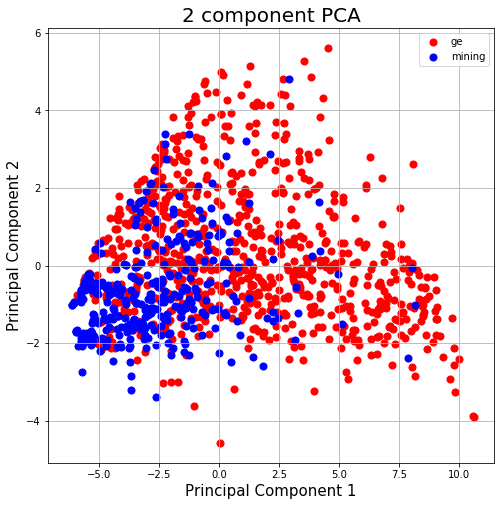

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['ge', 'mining']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Location'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Attempting 3D K-Means Clustering

In [34]:
from sklearn.cluster import KMeans
from sklearn import datasets
kept_features = ['skills_above_10', 'skill_mean', 'skill_std']
split_cluster_df = eng_df_selected.loc[eng_df_selected['Location'].isin(['mining', 'ge'])] # Limit first trial to two locations
split_cluster_df = split_cluster_df.reset_index(drop=True)
cluster_df = split_cluster_df.loc[:, kept_features]

print(cluster_df.shape)
X = cluster_df.values
# print(X)

#KMeans
km = KMeans(n_clusters=5, random_state=3425)
km.fit(X)
km.predict(X)
labels = km.labels_

(1124, 3)


In [35]:
print(len(labels))

1124


In [36]:
# Visualize cluster shapes in 3d (Credits to: https://www.bigendiandata.com/2017-04-18-Jupyter_Customer360/)
cluster_df['y'] = labels

cluster1 = cluster_df.loc[cluster_df['y'] == 0]
cluster2 = cluster_df.loc[cluster_df['y'] == 1]
cluster3 = cluster_df.loc[cluster_df['y'] == 2]
cluster4 = cluster_df.loc[cluster_df['y'] == 3]
cluster5 = cluster_df.loc[cluster_df['y'] == 4]


cluster1.head()

skills_above_10  skill_mean  skill_std  y
5                 3    7.866667  16.365760  0
15                1    4.400000  13.168143  0
24                4    7.733333  11.460907  0
44                4   11.133333  11.728273  0
45                1    5.200000  13.970377  0

In [37]:
scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.values[:,0], y = cluster1.values[:,1], z = cluster1.values[:,2],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.values[:,0], y = cluster2.values[:,1], z = cluster2.values[:,2],
    marker = dict( size=2, color='blue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.values[:,0], y = cluster3.values[:,1], z = cluster3.values[:,2],
    marker = dict( size=2, color='red')
)
scatter4 = dict(
    mode = "markers",
    name = "Cluster 4",
    type = "scatter3d",    
    x = cluster4.values[:,0], y = cluster4.values[:,1], z = cluster4.values[:,2],
    marker = dict( size=2, color='yellow')
)
scatter5 = dict(
    mode = "markers",
    name = "Cluster 5",
    type = "scatter3d",    
    x = cluster5.values[:,0], y = cluster5.values[:,1], z = cluster5.values[:,2],
    marker = dict( size=2, color='purple')
)
cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.values[:,0], y = cluster1.values[:,1], z = cluster1.values[:,2],
    color='green', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.values[:,0], y = cluster2.values[:,1], z = cluster2.values[:,2],
    color='blue', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3.values[:,0], y = cluster3.values[:,1], z = cluster3.values[:,2],
    color='red', showscale = True
)
cluster4 = dict(
    alphahull = 5,
    name = "Cluster 4",
    opacity = .1,
    type = "mesh3d",    
    x = cluster4.values[:,0], y = cluster4.values[:,1], z = cluster4.values[:,2],
    color='yellow', showscale = True
)
cluster5 = dict(
    alphahull = 5,
    name = "Cluster 5",
    opacity = .1,
    type = "mesh3d",    
    x = cluster5.values[:,0], y = cluster5.values[:,1], z = cluster5.values[:,2],
    color='purple', showscale = True
)
layout = dict(
    title = 'Interactive Cluster Shapes in 3D',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2, scatter3, scatter4, scatter5, \
                  cluster1, cluster2, cluster3, cluster4, cluster5], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='mesh3d_sample')

In [38]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

split_cluster_df['y'] = labels

In [39]:
split_cluster_df.loc[split_cluster_df['y'] == 4].head(5)

Name  equip_count Location  skills_above_10  Base_level  Melee_level  Range_level  Magic_level  Combat_level  Attack  Defence  Strength  \
2   ImFatNotCute            0       ge               14       36.00       38.025       36.075       28.275            74      60       55        57   
6            70x            9       ge               14       53.25       59.150       43.875       41.925           112      83       81        99   
8      Slayer3kk            0       ge               15       44.50       50.050       38.025       32.500            94      74       70        80   
13   NevGotRRekt            9       ge               15       47.75       52.650       38.350       22.425           100      79       77        83   
19   Prince Dios            8       ge               15       35.00       40.625       19.825       21.775            75      64       60        61   

    Hitpoints  Ranged  Prayer  Magic  Cooking  Woodcutting  Runecrafting  Fishing  Firemaking  Crafting  Smithing  Mining  skill_mean  skill_std  \
2          68      74      42     58       50           43             9       24          41        44        40      41   47.066667  16.425010   
6          94      90      77     86       59           90            38       18          61        51         1      51   65.266667  29.141200   
8          78      78      61     67       54           60            40       54          72        56        60      59   64.200000  11.219880   
13         82      79      65     46       69           50            32       27          71        55        29      27   58.066667  21.445834   
19         61      41      38     45       64           51            18       63          49        46        61      64   52.400000  13.162718   

    mining_minus_mean  y  
2                  -7  4  
6                 -15  4  
8                  -6  4  
13                -32  4  
19                 11  4

In [40]:
split_cluster_df.loc[split_cluster_df['y'] == 0].tail(5)

Name  equip_count Location  skills_above_10  Base_level  Melee_level  Range_level  Magic_level  Combat_level  Attack  Defence  \
1111  LA_P3SADILLA            1   mining                4        2.75        0.650        0.325        0.325             3       1        1   
1112    luna aazul            3   mining                3        3.25        3.575        0.325        0.325             6      10        1   
1113       Pharmar            4   mining                9        9.50        4.875        0.325       13.000            22      14       11   
1121    3skilllife            2   mining                3        2.75        0.650        0.325        0.325             3       1        1   
1123  Barnsie4Moop            4   mining                2        0.50        0.650        0.325        0.325             1       1        1   

      Strength  Hitpoints  Ranged  Prayer  Magic  Cooking  Woodcutting  Runecrafting  Fishing  Firemaking  Crafting  Smithing  Mining  skill_mean  \
1111         1         10       1       1      1       34           40             1       35          40         1         1       1   11.266667   
1112         1         11       1       2      1        1            1             1        1           1         1        13      52    6.533333   
1113         1         18       1      18     27       19           28             1        1          33         5        10      31   14.533333   
1121         1         10       1       1      1        2           55             1       50           1         1        15       1    9.466667   
1123         1          1       1       1      1       40           45             1        1           1         1         1       1    6.533333   

      skill_std  mining_minus_mean  y  
1111  16.446739                -11  0  
1112  13.276546                 45  0  
1113  11.494512                 16  0  
1121  17.967696                 -9  0  
1123  14.632970                 -6  0

In [41]:
split_cluster_df.loc[split_cluster_df['y'] == 3].head(5)

Name  equip_count Location  skills_above_10  Base_level  Melee_level  Range_level  Magic_level  Combat_level  Attack  Defence  Strength  \
12  D34DSH0T2369            9       ge               15       39.25       42.575       35.100       35.425            81      66       60        65   
34       Dudentp            1       ge               15       59.25       64.350       45.175       43.875           123      99       99        99   
42          XOXP            6       ge               15       49.25       54.925       40.300       37.050           104      85       77        84   
50     beastlyOG            8       ge               15       54.00       62.075       44.850       40.950           116      92       85        99   
58      Kidz Emo            9       ge               15       54.25       53.950       38.350       35.100           108      85       83        81   

    Hitpoints  Ranged  Prayer  Magic  Cooking  Woodcutting  Runecrafting  Fishing  Firemaking  Crafting  Smithing  Mining  skill_mean  skill_std  \
12         69      72      57     73       67           78            36       63          58        75        86      87   67.466667  12.591758   
34         99      93      78     90       70           63            43       69          65        65        74      68   78.266667  17.281149   
42         85      83      70     76       66           55            46       63          60        70        70      68   70.533333  11.544118   
50         96      92      70     84       70           64            35       66          52        70        70      57   73.466667  17.919928   
58         85      79      99     72       99           85            48       80          82        99        62      72   80.733333  13.734558   

    mining_minus_mean  y  
12                 19  3  
34                -11  3  
42                 -3  3  
50                -17  3  
58                 -9  3

In [42]:
print(split_cluster_df.loc[split_cluster_df['y'] == 0]['Location'].value_counts())
print(split_cluster_df.loc[split_cluster_df['y'] == 1]['Location'].value_counts())
print(split_cluster_df.loc[split_cluster_df['y'] == 2]['Location'].value_counts())
print(split_cluster_df.loc[split_cluster_df['y'] == 3]['Location'].value_counts())
print(split_cluster_df.loc[split_cluster_df['y'] == 4]['Location'].value_counts())

mining    155
ge        108
Name: Location, dtype: int64
ge        192
mining     46
Name: Location, dtype: int64
ge        195
mining    134
Name: Location, dtype: int64
ge        120
mining      3
Name: Location, dtype: int64
ge        158
mining     13
Name: Location, dtype: int64


Notice that players in Cluster 4 and 5 are very unlikely to be bots (Cluster 2 pretty unlikely as well). Hence, we may take just the players from Cluster 1 and 3 (index 0 and 2) to do another round of clustering.

In [43]:
kept_features = ['skills_above_10', 'skill_mean', 'skill_std']
split_cluster_df2 = split_cluster_df.loc[split_cluster_df['y'].isin([0, 2])] # Limit first trial to two locations
split_cluster_df2 = split_cluster_df2.reset_index(drop=True)
cluster_df = split_cluster_df2.loc[:, kept_features]

print(cluster_df.shape)
X = cluster_df.values
# print(X)

#KMeans
km = KMeans(n_clusters=5, random_state=3425)
km.fit(X)
km.predict(X)
labels = km.labels_

(592, 3)


In [44]:
# Visualize cluster shapes in 3d (Credits to: https://www.bigendiandata.com/2017-04-18-Jupyter_Customer360/)
cluster_df['y'] = labels

cluster1 = cluster_df.loc[cluster_df['y'] == 0]
cluster2 = cluster_df.loc[cluster_df['y'] == 1]
cluster3 = cluster_df.loc[cluster_df['y'] == 2]
cluster4 = cluster_df.loc[cluster_df['y'] == 3]
cluster5 = cluster_df.loc[cluster_df['y'] == 4]


cluster1.head()

skills_above_10  skill_mean  skill_std  y
0                 9   24.666667  19.382122  0
3                 9   24.600000  21.033307  0
5                13   27.400000  15.216532  0
13               11   25.133333  16.251886  0
14               11   23.666667  16.994397  0

In [45]:
scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.values[:,0], y = cluster1.values[:,1], z = cluster1.values[:,2],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.values[:,0], y = cluster2.values[:,1], z = cluster2.values[:,2],
    marker = dict( size=2, color='blue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.values[:,0], y = cluster3.values[:,1], z = cluster3.values[:,2],
    marker = dict( size=2, color='red')
)
scatter4 = dict(
    mode = "markers",
    name = "Cluster 4",
    type = "scatter3d",    
    x = cluster4.values[:,0], y = cluster4.values[:,1], z = cluster4.values[:,2],
    marker = dict( size=2, color='yellow')
)
scatter5 = dict(
    mode = "markers",
    name = "Cluster 5",
    type = "scatter3d",    
    x = cluster5.values[:,0], y = cluster5.values[:,1], z = cluster5.values[:,2],
    marker = dict( size=2, color='purple')
)
cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.values[:,0], y = cluster1.values[:,1], z = cluster1.values[:,2],
    color='green', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.values[:,0], y = cluster2.values[:,1], z = cluster2.values[:,2],
    color='blue', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3.values[:,0], y = cluster3.values[:,1], z = cluster3.values[:,2],
    color='red', showscale = True
)
cluster4 = dict(
    alphahull = 5,
    name = "Cluster 4",
    opacity = .1,
    type = "mesh3d",    
    x = cluster4.values[:,0], y = cluster4.values[:,1], z = cluster4.values[:,2],
    color='yellow', showscale = True
)
cluster5 = dict(
    alphahull = 5,
    name = "Cluster 5",
    opacity = .1,
    type = "mesh3d",    
    x = cluster5.values[:,0], y = cluster5.values[:,1], z = cluster5.values[:,2],
    color='purple', showscale = True
)
layout = dict(
    title = 'Interactive Cluster Shapes in 3D',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2, scatter3, scatter4, scatter5, \
                  cluster1, cluster2, cluster3, cluster4, cluster5], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='mesh3d_sample')

In [46]:
split_cluster_df2 = split_cluster_df2.drop(['y'], axis=1)
split_cluster_df2['y'] = labels

In [47]:
split_cluster_df2.loc[split_cluster_df2['y'] == 2].head(5)

Name  equip_count Location  skills_above_10  Base_level  Melee_level  Range_level  Magic_level  Combat_level  Attack  Defence  Strength  \
4     trippieYJ            8       ge                4       13.75       34.125        0.325       33.150            47      40        1        65   
9          K1d5            7       ge                8       22.00       26.325        0.325        0.325            48      40       40        41   
11  Cesarhfer68            0       ge                4       16.50       10.725        0.325       45.175            61      32        1         1   
19         G-R8            8       ge                5       13.75       17.550       29.250        0.325            43      53        1         1   
27  killing1238            9       ge                6       23.50       32.175        0.325       14.950            55      49       40        50   

    Hitpoints  Ranged  Prayer  Magic  Cooking  Woodcutting  Runecrafting  Fishing  Firemaking  Crafting  Smithing  Mining  skill_mean  skill_std  \
4          54       1       1     68        3            3             1        2           3         1         3       3   16.600000  25.753779   
9          40       1      16      1       52            3             1       47           5         3         1      15   20.400000  20.141641   
11         44       1      43     93        4            1             1        1           1         1         1      10   15.666667  26.593948   
19         54      60       1      1        1            1             1        1          39        31         1       1   16.466667  23.527694   
27         47       1      14     31        4            1             1        1           1         1         1       1   16.200000  20.623149   

    mining_minus_mean  y  
4                 -14  2  
9                  -6  2  
11                 -6  2  
19                -16  2  
27                -16  2

In [48]:
split_cluster_df2.loc[split_cluster_df2['y'] == 1].head(5)

Name  equip_count Location  skills_above_10  Base_level  Melee_level  Range_level  Magic_level  Combat_level  Attack  Defence  Strength  \
2     fordayouth            6       ge                3       11.50        0.650        0.325       29.250            40       1       21         1   
6      marcanoec            1       ge                1        0.50        0.650        0.325        0.325             1       1        1         1   
8   qqnjsay45454            2       ge                4        5.75        2.925        0.325       10.075            15       8        8         1   
15     egfvk3953            7       ge                4        7.50        5.525        0.325       18.850            26       7        6        10   
16   Ironwight66            0       ge                1        2.75        0.650        0.325        0.325             3       1        1         1   

    Hitpoints  Ranged  Prayer  Magic  Cooking  Woodcutting  Runecrafting  Fishing  Firemaking  Crafting  Smithing  Mining  skill_mean  skill_std  \
2          25       1       1     60        1            1             1        1           1         1         1       1    7.866667  16.365760   
6           1       1       1      1        1           52             1        1           1         1         1       1    4.400000  13.168143   
8          15       1       1     21        1           13             1        1           1         1         1      42    7.733333  11.460907   
15         20       1       8     39        3            2             5        2           9         1        23      31   11.133333  11.728273   
16         10       1       1      1        1           55             1        1           1         1         1       1    5.200000  13.970377   

    mining_minus_mean  y  
2                  -7  1  
6                  -4  1  
8                  34  1  
15                 19  1  
16                 -5  1

In [49]:
print(split_cluster_df2.loc[split_cluster_df2['y'] == 0]['Location'].value_counts())
print(split_cluster_df2.loc[split_cluster_df2['y'] == 1]['Location'].value_counts())
print(split_cluster_df2.loc[split_cluster_df2['y'] == 2]['Location'].value_counts())
print(split_cluster_df2.loc[split_cluster_df2['y'] == 3]['Location'].value_counts())
print(split_cluster_df2.loc[split_cluster_df2['y'] == 4]['Location'].value_counts())

ge        76
mining    66
Name: Location, dtype: int64
mining    97
ge        48
Name: Location, dtype: int64
ge        80
mining    58
Name: Location, dtype: int64
mining    58
ge        48
Name: Location, dtype: int64
ge        51
mining    10
Name: Location, dtype: int64


In [50]:
pd.reset_option('display')

## Original Tests

In [ ]:
player_df['Magic'].round(decimals=-1).value_counts().sort_index(ascending=True)

In [ ]:
player_df['Mining'].round(decimals=-1).value_counts().sort_index(ascending=True).plot.bar()

In [ ]:
ge_df = player_df.loc[player_df['Location'] == 'ge']

print(ge_df.shape)
ge_df.head()

In [ ]:
ge_df['Mining'].round(decimals=-1).value_counts().sort_index(ascending=True).plot.bar()

In [ ]:
mining_df = player_df.loc[player_df['Location'] == 'mining']

print(mining_df.shape)
mining_df.head()

In [ ]:
mining_df['Mining'].round(decimals=-1).value_counts().sort_index(ascending=True).plot.bar()

In [ ]:
mining_df['Mining'].hist()

In [ ]:
mining_df[f2p_array].hist(color='k', alpha=0.5, bins=10)

In [ ]:
for skill in f2p_array:
    print("{}: {}".format(skill, mining_df[skill].value_counts()[1]))

In [ ]:
# Initialize plotting library and functions for 3D scatter plots 
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_classification, make_regression
from sklearn.externals import six
import pandas as pd
import numpy as np
import argparse
import json
import re
import os
import sys
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

In [ ]:
def rename_columns(df, prefix='x'):
    """
    Rename the columns of a dataframe to have X in front of them

    :param df: data frame we're operating on
    :param prefix: the prefix string
    """
    df = df.copy()
    df.columns = [prefix + str(i) for i in df.columns]
    return df

In [ ]:
# Create an artificial dataset with 3 clusters for 3 feature columns
X, Y = make_classification(n_samples=100, n_classes=3, n_features=3, n_redundant=0, n_informative=3,
                             scale=1000, n_clusters_per_class=1)
df = pd.DataFrame(X)
# rename X columns
df = rename_columns(df)
# and add the Y
df['y'] = Y
df.head(3)

In [ ]:
# Visualize cluster shapes in 3d.

cluster1=df.loc[df['y'] == 0]
cluster2=df.loc[df['y'] == 1]
cluster3=df.loc[df['y'] == 2]

cluster1.values[:, 0]

In [ ]:

scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.values[:,0], y = cluster1.values[:,1], z = cluster1.values[:,2],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.values[:,0], y = cluster2.values[:,1], z = cluster2.values[:,2],
    marker = dict( size=2, color='blue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.values[:,0], y = cluster3.values[:,1], z = cluster3.values[:,2],
    marker = dict( size=2, color='red')
)
cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.values[:,0], y = cluster1.values[:,1], z = cluster1.values[:,2],
    color='green', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.values[:,0], y = cluster2.values[:,1], z = cluster2.values[:,2],
    color='blue', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3.values[:,0], y = cluster3.values[:,1], z = cluster3.values[:,2],
    color='red', showscale = True
)
layout = dict(
    title = 'Interactive Cluster Shapes in 3D',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2, scatter3, cluster1, cluster2, cluster3], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='mesh3d_sample')

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline
from sklearn import datasets

#Iris Dataset
iris = datasets.load_iris()
X = iris.data
#KMeans
km = KMeans(n_clusters=3)
km.fit(X)
km.predict(X)
labels = km.labels_

#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X[:, 3], X[:, 0], X[:, 2],
          c=labels.astype(np.float), edgecolor="k", s=50)
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
plt.title("K Means", fontsize=14)